# MODIS Water Histogram-based Gradient Boosting Classification Tree

Version: 0.1.0

Date modified: 04.21.2022

Modified by: Caleb Spradlin

In [5]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
import optuna
import sys
import warnings 

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

sys.path.append('../scripts/')
import notebook_util as nu

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [6]:
FIGURE_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

training_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.1.0'

qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/css/modis/Collection6.1/'

GPU = True
TILE = 'Golden'
MODEL = 'xgboost'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day',]# 'tileID']
# Columns that the user wants to drop for training purposes. 
colsToDrop = []# ['sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [7]:
if GPU:
    nu.setup_one_gpu() # Choose the GPU with the lowest memory usage

Picking GPU 0


In [8]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF or pandas Dataframe
- Drop unnecessary columns
- Clean data
- Split into Xs and Ys
- Train-test split

In [9]:
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
data_paths = sorted([fv for fv in glob.glob(glob_string)])
data_path = data_paths[0]
pprint(data_paths)
print(data_path)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.1.0/MOD09_Golden_Masked_5500000_4_1_0.parquet.gzip',
 '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.1.0/MOD09_Golden_Masked_865249_Water_Imbalance_4_2_0.parquet.gzip',
 '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.1.0/MOD09_Golden_Masked_957000_4_2_0.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.1.0/MOD09_Golden_Masked_5500000_4_1_0.parquet.gzip


In [10]:
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDropTraining,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             imbalance=False,
                                             trainTestSplit=True,
                                             multi=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [11]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,3282777.0,842.087749,991.236711,-100.0,162.0,644.0,1073.0,13141.0
sur_refl_b02_1,3282777.0,1653.180023,1325.240457,-100.0,169.0,1877.0,2570.0,12205.0
sur_refl_b03_1,3282777.0,512.919203,696.187386,-100.0,178.0,343.0,571.0,9119.0
sur_refl_b04_1,3282777.0,736.589213,800.641645,-100.0,274.0,612.0,878.0,9533.0
sur_refl_b05_1,3282777.0,1890.558480,1472.349900,-100.0,146.0,2263.0,3108.0,9383.0
sur_refl_b06_1,3282777.0,1638.825929,1387.792420,-100.0,160.0,1591.0,2660.0,7855.0
sur_refl_b07_1,3282777.0,1081.700977,1091.707114,-100.0,71.0,808.0,1705.0,9357.0
ndvi,3282777.0,456.062576,6803.247698,-32762.0,-1818.0,2495.0,5006.0,32727.0
ndwi1,3282777.0,-2059.548562,5552.067248,-32758.0,-2866.0,-874.0,765.0,32762.0
ndwi2,3282777.0,-33.618318,7036.184160,-32727.0,-1266.0,951.0,4177.0,32762.0


# Model definition and training

## Training the model with the best hyperparamers

In [12]:
params = {'categorical_features': None,
 'early_stopping': 'auto',
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'auto',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 1000,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 42,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [13]:
classifier = HistGradientBoostingClassifier(**params)

In [14]:
classifier.fit(X_train, y_train)

HistGradientBoostingClassifier(loss='auto', max_iter=1000, random_state=42)

## Model testing and training/testing data validation

### Get model metrics

In [15]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.977

In [16]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [17]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [18]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
# From docs: tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp = confusion_matrix(y_test_int, test_predictions).ravel()
recall = (tp / (tp + fp))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('\nTest Matthews Correlation Coefficient (MCC)')
print('-------------------------------------------------------')
mcc = matthews_corrcoef(y_test_int, test_predictions)
print(mcc)
print('\nConfusion Matrix')
print('-------------------------------------------------------')
print('TP: {:9} FN: {:9}'.format(tp, fn))
print('FP: {:9} TN: {:9}'.format(fp, tn))

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    582640
           1       0.98      0.97      0.98    511619

    accuracy                           0.98   1094259
   macro avg       0.98      0.98      0.98   1094259
weighted avg       0.98      0.98      0.98   1094259

Test Recall
-------------------------------------------------------
0.9795419058734465

Test Matthews Correlation Coefficient (MCC)
-------------------------------------------------------
0.9538617135643451

Confusion Matrix
-------------------------------------------------------
TP:    496855 FN:     14764
FP:     10377 TN:    572263


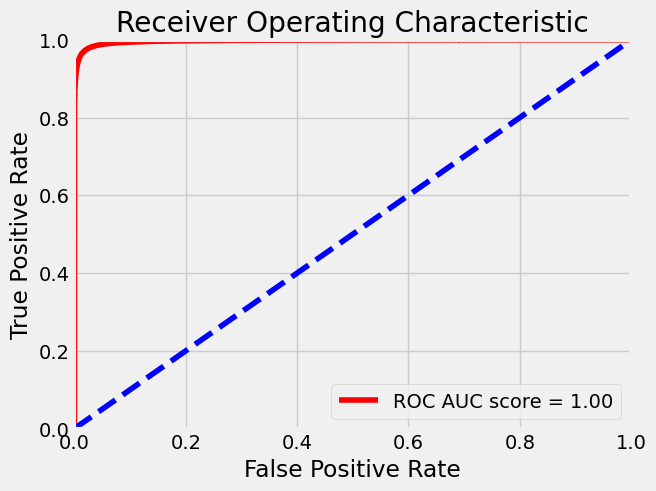

In [19]:
clf = classifier

probs = clf.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.show()

### Permutaion importance

In [20]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=5,
                                                        random_state=42)

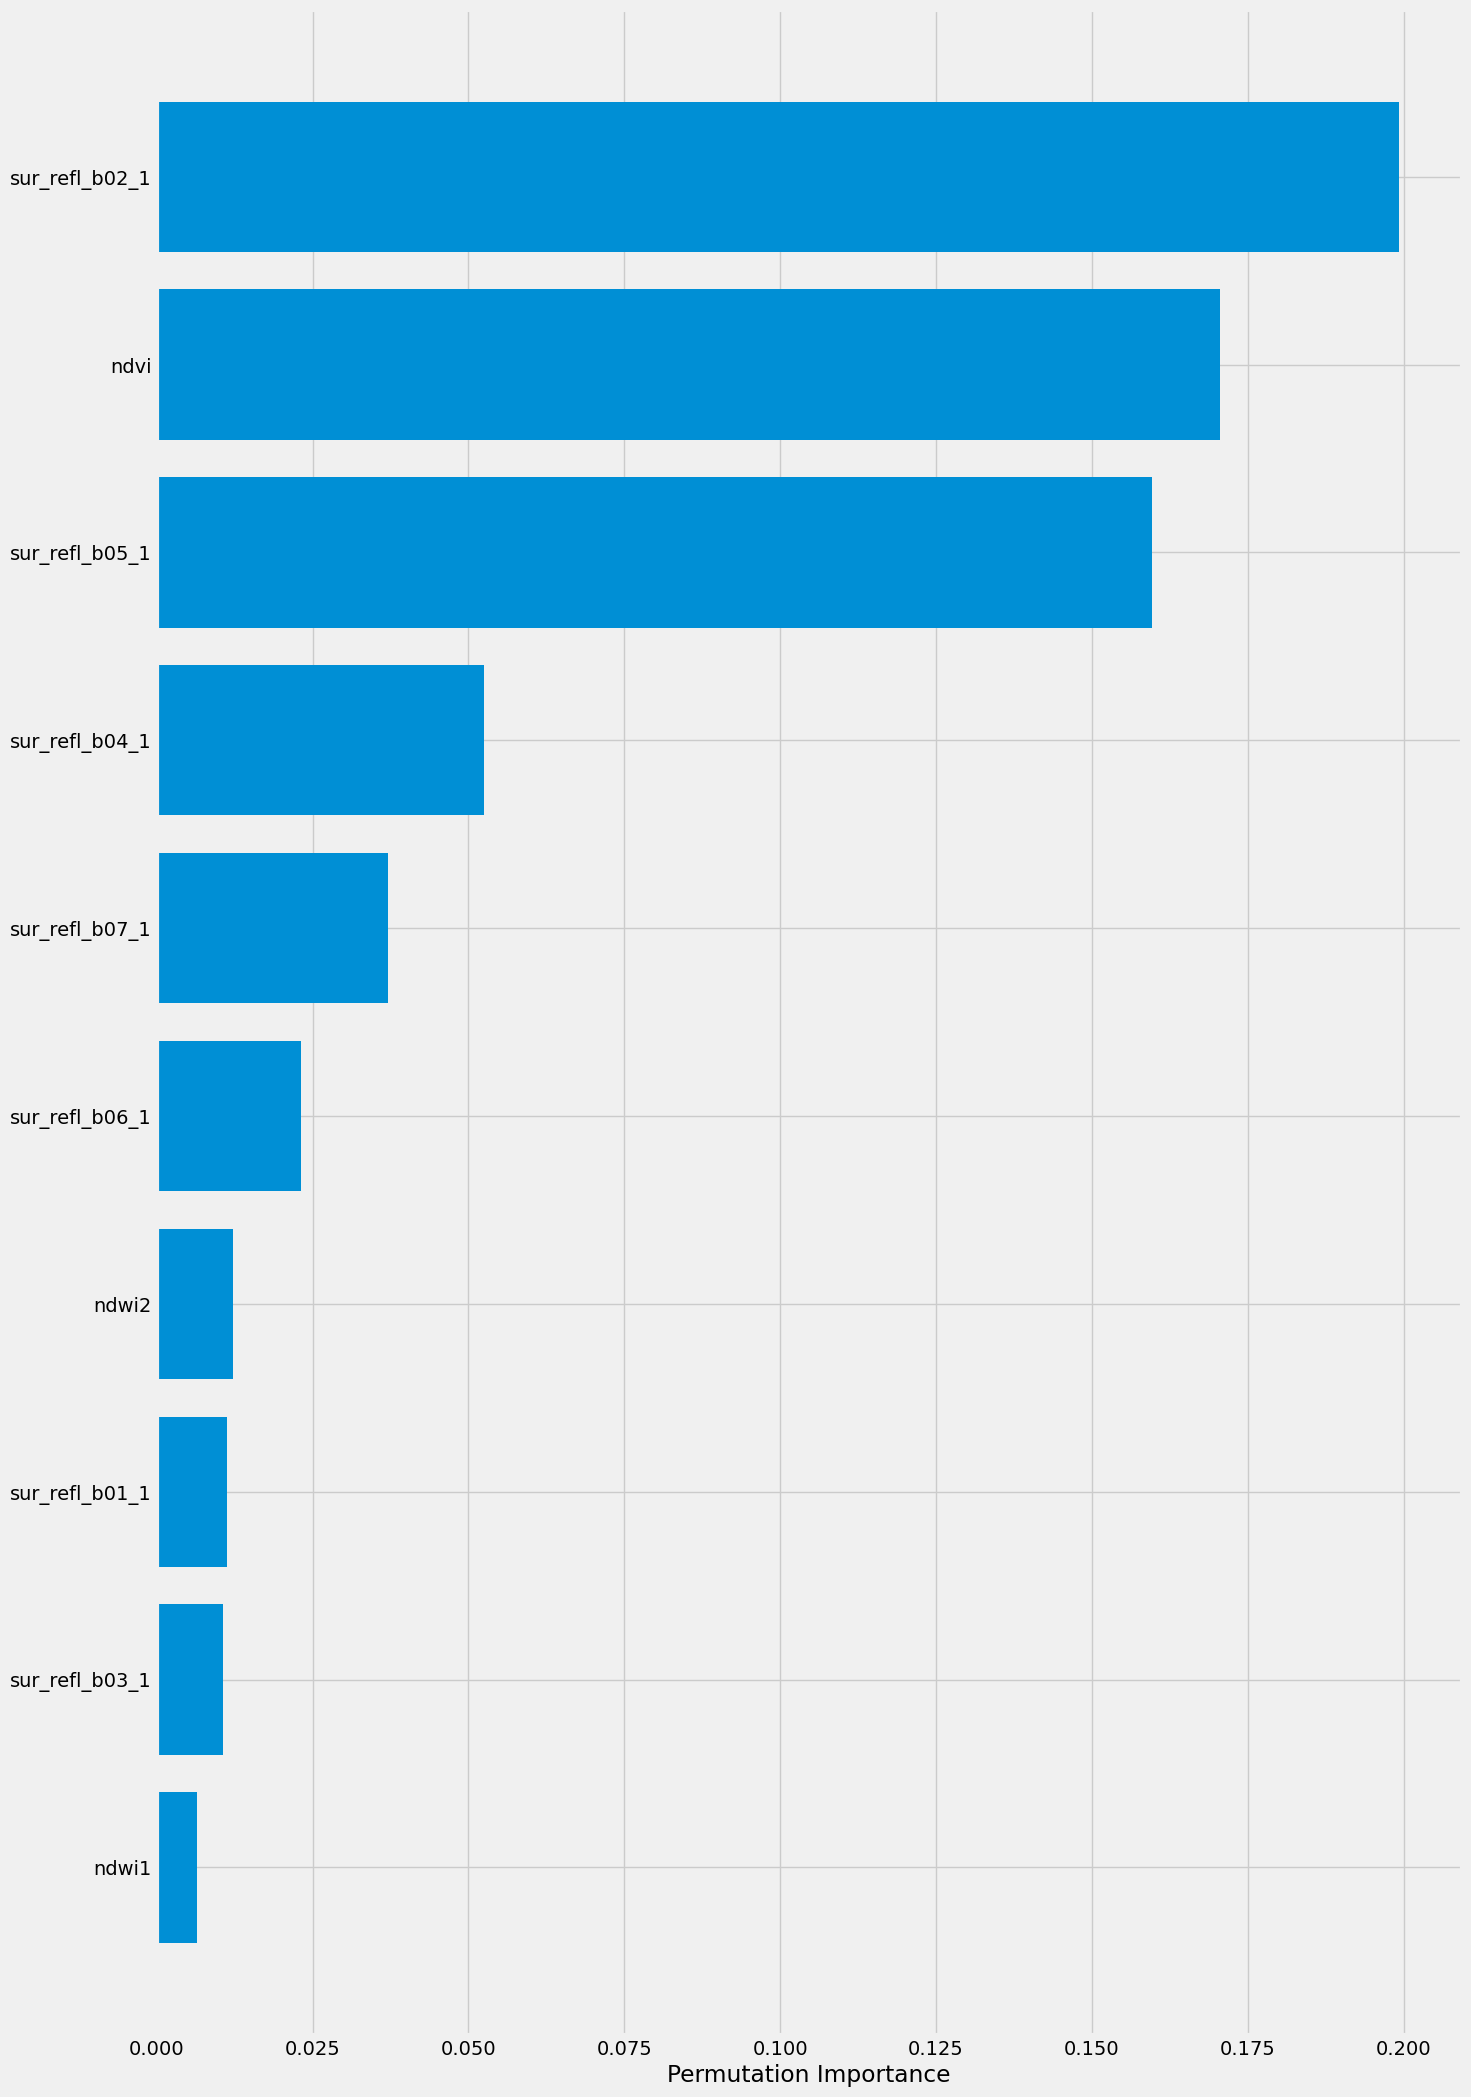

In [21]:
png_save_path = 'mw_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    MODEL,
    params['max_iter'],
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(15, 25))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
# plt.savefig(png_save_path)

Garbage collection

## Save the model for future use

In [22]:
model_save_path = 'mw_{}_{}_{}_{}_4.2.0_2_{}.sav'.format(TILE,
                                                              score,
                                                              MODEL,
                                                              params['max_iter'],
                                                              'cpu',
                                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.977_xgboost_1000_4.2.0_2_cpu.sav
HistGradientBoostingClassifier(loss='auto', max_iter=1000, random_state=42)


['/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.977_xgboost_1000_4.2.0_2_cpu.sav']

# Testing: raster testing

In [23]:
import sys
sys.path.append('../../..')
from modis_water_training.model.TabularModisDataGenerator import TabularModisDataGenerator

In [24]:
TILE = 'h11v10'
DAY = 201
YEAR = 2006
PATH = os.path.join(test_data_basepath, '{}/'.format(TILE))

In [25]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

/css/modis/Collection6.1/L2G/MOD09GA/2006/*GA.A2006201.h11v10*.hdf
/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf
Julian day: 201
Files: {'SensorZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SensorZenith_1', 'SolarZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SolarZenith_1', 'state_1km_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:state_1km_1', 'sur_refl_b03_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1', 'sur_refl_b04_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1', 'sur_refl_b05_1':

In [26]:
vars_list_gq = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list

['HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b01_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b02_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b06_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_r

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [27]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [28]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 282 2985  173 ... 8273 2822 6797]
 [ 289 3045  173 ... 8266 2913 6851]
 [ 275 3198  180 ... 8416 3050 6898]
 ...
 [ 317 1559  144 ... 6620  562 4395]
 [ 252 1447  126 ... 7033  770 4863]
 [ 252 1447  126 ... 7033  770 4863]]
460.8 MB size


In [29]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [ ]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [31]:
shp = (4800,4800)
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

NameError: name 'predictedRaster' is not defined

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [ ]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

In [ ]:
waterMaskMatrix

### Mask out results if QA Mask says pixel is "bad"

In [ ]:
maskedResult = np.where(qaMaskMatrix == 0, reshp, 255)
waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, 255)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

# Generating stats for predicted and truth

## Metrics on test raster

In [ ]:
import math

In [ ]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))
mcc_denom_nosqrt = (truePositives+falsePositives)*(truePositives+falseNegatives)*(trueNegatives+falsePositives)*(trueNegatives+falseNegatives)
mcc_numerator = (truePositives*trueNegatives) - (falsePositives*falseNegatives)
mcc = mcc_numerator/math.sqrt(mcc_denom_nosqrt)

### Count num of occurences for each class with the masked predicted result

In [ ]:
countNoData = np.count_nonzero(maskedResult == 255)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

### Count num of occurences for each class with the water mask

In [ ]:
countNoDataT = np.count_nonzero(waterMasked == 255)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Min. extent water mask vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

### Model metrics on raster data

In [ ]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print("Jian's metric : {}".format(jians))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))
print('MCC: {}'.format(mcc))

## Output predicted raster to GeoTiff

In [ ]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

## Folium Viewing

In [ ]:
import folium
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 

In [ ]:
# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

In [ ]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

 https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/{LayerIdentifier}/default/{Time}/{TileMatrixSet}/{TileMatrix}/{TileRow}/{TileCol}.{FormatExt}

https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/MODIS_Terra_CorrectedReflectance_TrueColor/default/2012-07-09/250m/6/13/36.jpg

In [ ]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)

In [ ]:
from folium import plugins

In [ ]:
m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())

## Model prediction explainability

In [ ]:
from matplotlib.patches import Rectangle

Known false positives square:

- h11v10:
```
y = (3000, 3000+250)
x = (1020, 1020+230)
```

In [ ]:
maskToShow = np.where(maskedResult==255, -1, maskedResult)
waterMaskToShow = np.where(waterMasked==255, -1, waterMasked)
y = (2150, 2150+250)
x = (1400, 1400+230)
width = x[1] - x[0]
height = y[1] - y[0]

In [ ]:
plt.figure(figsize=(20, 20))
plt.matshow(maskToShow, fignum=1)
plt.gca().add_patch(Rectangle((x[0],y[0]),width,height,
                    edgecolor='red',
                    facecolor='none',
                    lw=4))
plt.colorbar()

In [ ]:
plt.figure(figsize=(20, 20))
plt.matshow(waterMaskToShow, fignum=1)
plt.gca().add_patch(Rectangle((x[0],y[0]),width,height,
                    edgecolor='red',
                    facecolor='none',
                    lw=4))
plt.title('MOD44W Tile: {}, Year: {}, Day: {}'.format(TILE, YEAR, DAY))
plt.colorbar()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 12))

ax1, ax2 = axes

im1 = ax1.matshow(maskToShow[y[0]:y[1], x[0]:x[1]])
im2 = ax2.matshow(waterMaskToShow[y[0]:y[1], x[0]:x[1]])

ax1.set_title('Predicted Mask')
ax2.set_title('MOD44W Mask')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [ ]:
def readRaster(vars_list, x, y, colsToDrop=None):
    min_right, max_right = x
    min_bottom, max_bottom = y
    cols = max_bottom - min_bottom
    rows = max_right - min_right
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (cols, rows, len(index_names.keys()))
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, :, b] = dd.GetRasterBand(b+1).ReadAsArray()[min_bottom:max_bottom, min_right:max_right].astype(np.int16)
    dd = None
    img[:, :, len(vars_list)] = ((img[:,:,1] - img[:,:,0]) / (img[:,:,1] + img[:,:,0])) * 10000
    img[:, :, len(vars_list)+1] = ((img[:,:,1] - img[:,:,5]) / (img[:,:,1] + img[:,:,5])) * 10000
    img[:, :, len(vars_list)+2] = ((img[:,:,1] - img[:,:,6]) / (img[:,:,1] + img[:,:,6])) * 10000
    for band, combo in band_combo.items():
        print('{} = {} x {}'.format(band, combo[0], combo[1]))
        print('{} = {} x {}'.format(index_names[band], index_names[combo[0]], index_names[combo[1]]))
        b0 = img[:, :, index_names[combo[0]]]
        b1 = img[:, :, index_names[combo[1]]]
        img[:, :, index_names[band]] = ((b0 - b1) / (b0 + b1)) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

def plot_comparison(mask, band, img):
    fig, axes = plt.subplots(ncols=2, figsize=(25, 12))

    ax1, ax2 = axes

    im1 = ax1.matshow(img[:, :, band-1])
    im2 = ax2.matshow(mask)
    band_name = band
    if band >=8 :
        if band == 8:
            band_name = 'ndvi'
        elif band == 9:
            band_name = 'ndwi1'
        elif band == 10:
            band_name = 'ndwi2'
            
    ax1.set_title('Tile: {} Day: {} Year: {} Band: {}'.format(TILE, DAY, YEAR, band_name))
    ax2.set_title('Tile: {} Day: {} Year: {} Predicted Water Mask'.format(TILE, DAY, YEAR))
    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)

def readRasterToArray(vars_list, x, y, colsToDrop=None):
    min_right, max_right = x
    min_bottom, max_bottom = y
    cols = max_bottom - min_bottom
    rows = max_right - min_right
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (cols*rows, len(index_names.keys()))
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray()[min_bottom:max_bottom, min_right:max_right].astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    for band, combo in band_combo.items():
        print('{}({}) = {}({}) x {}({})'.format(band, 
                                                index_names[band], 
                                                combo[0], 
                                                index_names[combo[0]], 
                                                combo[1],  
                                                index_names[combo[1]]))
        b0 = img[:, index_names[combo[0]]]
        b1 = img[:, index_names[combo[1]]]
        img[:, index_names[band]] = ((b0 - b1) / (b0 + b1)) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    df = pd.DataFrame(img, columns=index_names.keys(), dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    return df

def get_idx(idx, shape):
    idx_unr = np.unravel_index((idx,), shape)
    print(idx_unr)
    idx_unr = (idx_unr[0][0], idx_unr[1][0])
    return idx_unr

def plot_comparison_explain(mask, band, img, idx):
    y, x = get_idx(idx, shape=mask.shape)
    y = (y-5, y+5)
    x = (x-5, x+5)
    width = x[1]-x[0]
    height = y[1]-y[0]
    fig, axes = plt.subplots(ncols=2, figsize=(25, 12))

    ax1, ax2 = axes

    im1 = ax1.matshow(img[:, :, band-1])
    im2 = ax2.matshow(mask)
    shap.force_plot(explainer.expected_value[1], 
                    shap_test[:, :, 1].values[idx], 
                    feature_names=shap_test.feature_names, 
                    matplotlib=True, 
                    show=False)
    band_name = band
    if band >=8 :
        if band == 8:
            band_name = 'ndvi'
        elif band == 9:
            band_name = 'ndwi1'
        elif band == 10:
            band_name = 'ndwi2'
    ax1.add_patch(Rectangle((x[0],y[0]),width,height,
                        edgecolor='red',
                        facecolor='none',
                        lw=4))
    ax2.add_patch(Rectangle((x[0],y[0]),width,height,
                        edgecolor='red',
                        facecolor='none',
                        lw=4))
    ax1.set_title('Tile: {} Day: {} Year: {} Band: {}'.format(TILE, DAY, YEAR, band_name))
    ax2.set_title('Tile: {} Day: {} Year: {} Predicted Water Mask'.format(TILE, DAY, YEAR))
    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)

def findFP(x, y, mask, waterMask, df, n=20):
    indexIDList = [i for i in range(n)]
    y_preds = mask.ravel()
    y_mod44 = waterMask[y[0]:y[1], x[0]:x[1]].ravel()
    X_withPreds = df.assign(predicted=y_preds)
    X_withPreds = X_withPreds.assign(MOD44=y_mod44)
    predictedWater = X_withPreds[X_withPreds['predicted'] == 1]
    falsePositives = predictedWater[predictedWater['MOD44'] == 0]
    falsePositives = falsePositives.sample(frac=1)
    falsePositives = falsePositives.sample(n=n)
    falsePositives = falsePositives.assign(indexID=indexIDList)
    return falsePositives

In [ ]:
img = readRaster(vars_list, x, y, colsToDrop=colsToDrop)

Band key:

- 1 = sur_refl_b01
- 2 = sur_refl_b02
- 3 = sur_refl_b03
- 4 = sur_refl_b04
- 5 = sur_refl_b05
- 6 = sur_refl_b06
- 7 = sur_refl_b07
- 8 = ndvi
- 9 = ndwi1
- 10 = ndwi2

In [ ]:
mask = maskToShow[y[0]:y[1], x[0]:x[1]]
plot_comparison(mask=mask,
                band=18,
                img=img)

In [ ]:
X_expl = readRasterToArray(vars_list, x, y, colsToDrop)
X_expl

In [ ]:
try:
    import shap
except ModuleNotFoundError:
    !pip install shap
    import shap

In [ ]:
shap.initjs()

In [ ]:
bg_set = X_train.sample(n=500)
bg_set = bg_set.reset_index()
bg_set = bg_set.drop(columns=['index'])

In [ ]:
explainer = shap.explainers.Tree(model=classifier, data=bg_set, model_output='predict_proba')
shap_test = explainer(X_expl)
print(f"Length of shap_test: {len(shap_test)}\n")
print(f"Sample shap_test:\n{shap_test[0]}")

In [ ]:
print(f"Expected value: {explainer.expected_value[1]:.2f}")
print(f"Average target value (training data): {y_train.mean():.2f}")
print(f"Base value: {np.unique(shap_test.base_values)[0]:.2f}")

In [ ]:
shap_df = pd.DataFrame(shap_test.values[:,:,1], 
                       columns=shap_test.feature_names, 
                       index=X_expl.index)
shap_df

In [ ]:
np.isclose(classifier.predict_proba(X_expl)[:,1], 
           explainer.expected_value[1] + shap_df.sum(axis=1))

In [ ]:
shap.plots.bar(shap_test[:,:,1])

In [ ]:
columns = shap_df.apply(np.abs).mean().sort_values(ascending=False).index

fig, ax = plt.subplots(1, 2, figsize=(18,8))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h',ax=ax[0])
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

In [ ]:
shap.summary_plot(shap_test[:,:,1], plot_size=(17, 10), show=False)
plt.gcf().axes[-1].set_aspect(10)
plt.gcf().axes[-1].set_box_aspect(10)

In [ ]:
falsePositives = findFP(x, y, mask=mask, waterMask=waterMaskToShow, df=X_expl, n=20)
falsePositives

## Look through false positives

Using the dataframe above select by "indexID" which prediction we'd like to examine.

Band key:

- 1 = sur_refl_b01
- 2 = sur_refl_b02
- 3 = sur_refl_b03
- 4 = sur_refl_b04
- 5 = sur_refl_b05
- 6 = sur_refl_b06
- 7 = sur_refl_b07
- 8 = ndvi
- 9 = ndwi1
- 10 = ndwi2

In [ ]:
band = 2
index = 1

In [ ]:
plot_comparison_explain(mask, band, img, idx=falsePositives.index[index])

In [ ]:
pd.DataFrame(X_expl.iloc[falsePositives.index[index]]).T